### Import Libraries

In [1]:
from autocorrect import Speller
from datetime import datetime
from nltk.corpus import stopwords

import contractions
import nltk
import pandas as pd
import re
import string
import swifter

nltk.download('stopwords')

/home/rjj1512/miniconda3/envs/base_nlp/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/rjj1512/miniconda3/envs/base_nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rjj1512/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Get the data from CSV

In [2]:
df = pd.read_csv('patient_notes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


### Data Preprocessing

#### Converting notes to lowercase

In [3]:
df['pn_history'] = df['pn_history'].str.lower()

#### Expanding Contractions

In [4]:
df['pn_contracted_text'] = df['pn_history'].swifter.apply(lambda x: contractions.fix(x))

Pandas Apply:  24%|██▍       | 10016/42146 [00:00<00:01, 32030.48it/s]

Pandas Apply: 100%|██████████| 42146/42146 [00:01<00:00, 33065.33it/s]


#### Replacing Punctuations

In [5]:
def replace_punctuation_with_spaces(text):
    punctuation_regex = "[" + re.escape(string.punctuation) + "]"
    cleaned_text = re.sub(punctuation_regex, ' ', text)
    return cleaned_text

df['pn_contracted_text'] = df['pn_contracted_text'].swifter.apply(replace_punctuation_with_spaces).str.replace(r'\s+', ' ', regex=True)

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

Pandas Apply: 100%|██████████| 42146/42146 [00:00<00:00, 83608.03it/s]


#### Fixing Typos/Spelling.
##### Used Speller (Autocorrect Module) for this assignment, but we can use SpellChecker or better libs if the machine specs are better

In [6]:
def typo_spell(note):
    spell = Speller(fast=True)
    note = ' '.join(spell(word) for word in note.split())
    return note

df['pn_contracted_text'] = df['pn_contracted_text'].swifter.apply(typo_spell)

### The below additional functions can be used to speed up, but it didn't work for me properly.
#.allow_dask_on_strings().set_dask_scheduler(scheduler="threads").set_npartitions(8)

Pandas Apply: 100%|██████████| 42146/42146 [32:01<00:00, 21.93it/s]


#### Standardizing the data (dates, currencies, numerical data)

In [7]:
def standardize_formats(text):
    # Standardize date formats
    date_formats = [
        r'\b(\d{1,2})[-/](\d{1,2})[-/](\d{2,4})\b',  
        r'\b(\d{2,4})[-/](\d{1,2})[-/](\d{1,2})\b', 
    ]
    for date_format in date_formats:
        text = re.sub(date_format, lambda x: datetime(*map(int, x.groups())).strftime('%Y-%m-%d'), text)

    # Standardize currency formats
    text = re.sub(r'\$\s?(\d+(?:,\d{3})*(?:\.\d{1,2})?)', lambda x: '${:,.2f}'.format(float(x.group(1).replace(',', ''))), text)

    # Standardize huge numbers
    text = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', text)

    # Standardize decimals
    text = re.sub(r'(\d+),(\d+)', r'\1.\2', text)

    return text

df['pn_contracted_text'] = df['pn_contracted_text'].swifter.apply(standardize_formats)

Pandas Apply: 100%|██████████| 42146/42146 [00:01<00:00, 23045.62it/s]


#### Removing Stop words

In [8]:
def stop_words_return(note):
    stop_words = set(stopwords.words('english'))
    note = ' '.join(word for word in note.split() if word not in stop_words)
    return note

df['pn_contracted_text'] = df['pn_contracted_text'].swifter.apply(stop_words_return)

Pandas Apply: 100%|██████████| 42146/42146 [00:02<00:00, 14479.01it/s]


### Forming Document Term Matrix using TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  transforming text data into a DTM with TF-IDF weighting
TF_IDF_vectorizer = TfidfVectorizer(
     stop_words = 'english',
     max_df=0.85, # remove terms that is present in 85% of the data
     min_df=0.01, # remove infrequent terms (present in only 1% of the data)
)

# below is as same as the code in P3_BOW
dtm = TF_IDF_vectorizer.fit_transform(df['pn_contracted_text'])
feature_names = TF_IDF_vectorizer.get_feature_names_out()
df_dtm = pd.DataFrame(dtm.toarray(), columns=feature_names)
print(df_dtm.head())

# Analyzing the DTM DataFrame
print("\nDTM DataFrame Analysis:")
print("Size of the DTM DataFrame:", df_dtm.shape)
print(f"Memory usage of the DTM DataFrame: {df_dtm.memory_usage(deep=True).sum()} bytes")
print("Number of unique terms in DTM:", len(df_dtm.columns))
print("Type of data in DTM DataFrame:", df_dtm.dtypes.unique())

         10   11   12   13   14   15        17      17yo  1pp   1x  ...  \
0  0.000000  0.0  0.0  0.0  0.0  0.0  0.120936  0.000000  0.0  0.0  ...   
1  0.000000  0.0  0.0  0.0  0.0  0.0  0.189568  0.000000  0.0  0.0  ...   
2  0.060407  0.0  0.0  0.0  0.0  0.0  0.109430  0.000000  0.0  0.0  ...   
3  0.000000  0.0  0.0  0.0  0.0  0.0  0.136828  0.000000  0.0  0.0  ...   
4  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.171976  0.0  0.0  ...   

   worst        wt   x2   x3      year  years  yesterday        yo        yr  \
0    0.0  0.157179  0.0  0.0  0.073555    0.0        0.0  0.000000  0.000000   
1    0.0  0.000000  0.0  0.0  0.000000    0.0        0.0  0.096085  0.000000   
2    0.0  0.000000  0.0  0.0  0.000000    0.0        0.0  0.000000  0.000000   
3    0.0  0.000000  0.0  0.0  0.000000    0.0        0.0  0.069353  0.172446   
4    0.0  0.000000  0.0  0.0  0.000000    0.0        0.0  0.000000  0.000000   

   yrs  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 931

### Normalizing the DTM
#### Using IsolationForest for Outlier Analysis

In [10]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest

dtm = normalize(dtm)

# Want only 2.5% of outliers since data size is not that large
iso_forest = IsolationForest(contamination=0.025)  
outliers = iso_forest.fit_predict(dtm)

outlier_indices = np.where(outliers == -1)[0]

print(f"Number of Outliers Detected: {len(outlier_indices)}")
print(f"Indices of Outlier Rows: {outlier_indices}")

Number of Outliers Detected: 1054
Indices of Outlier Rows: [ 2288  2313  2315 ... 41882 41917 41926]


### Dimensionality Reduction

#### Using UMAP with 2 components, 0.5 min_dist and 40 neighbors with cosine distance metric

In [11]:
import umap
from matplotlib import pyplot as plt
umap_model = umap.UMAP(n_neighbors=40, min_dist=0.5, n_components=2, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(dtm)
X_umap.shape

/home/rjj1512/miniconda3/envs/base_nlp/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(42146, 2)

### Unsupervised ML Algorithm:
#### Gaussian Mixture Model (GMM) that can provide probabilities for every datapoint belonging to multiple clusters. Then it assigns the cluster with high probability.

#### We have used cross_val_score, BIC score and silhouette score to determine the number of clusters as per the graph.

#### The elbow shape can be found on clusters=8 or clusters=9. With n_clusters=9, we can see spaced out clusters in distinct colors

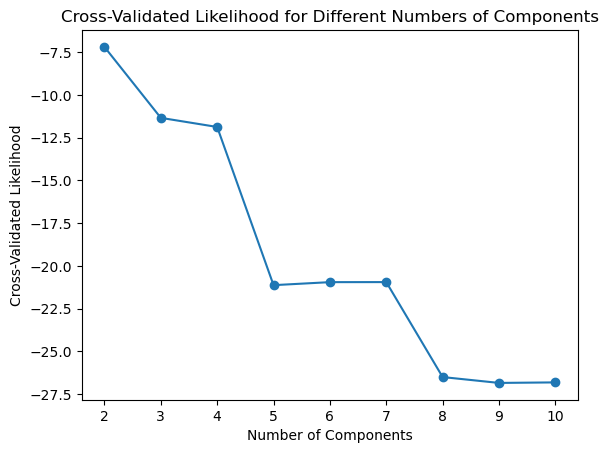

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score

n_components_range = range(2, 11)
likelihood_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, X_umap)
    likelihood_scores.append(np.median(scores))

plt.plot(n_components_range, likelihood_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Likelihood')
plt.title('Cross-Validated Likelihood for Different Numbers of Components')
plt.show()

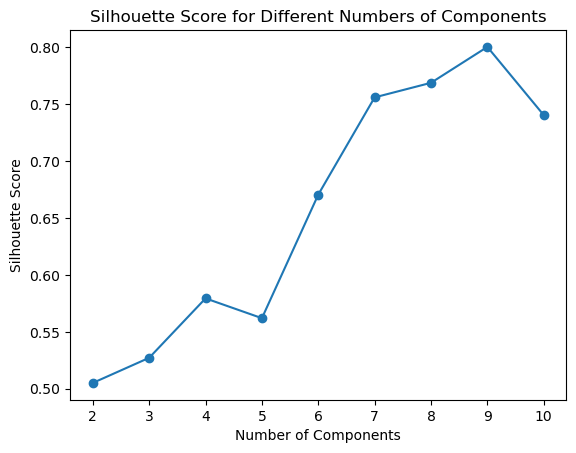

In [19]:
silhouette_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_assignments = gmm.fit_predict(X_umap)
    silhouette_scores.append(silhouette_score(X_umap, cluster_assignments))

plt.plot(range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Components')
plt.show()

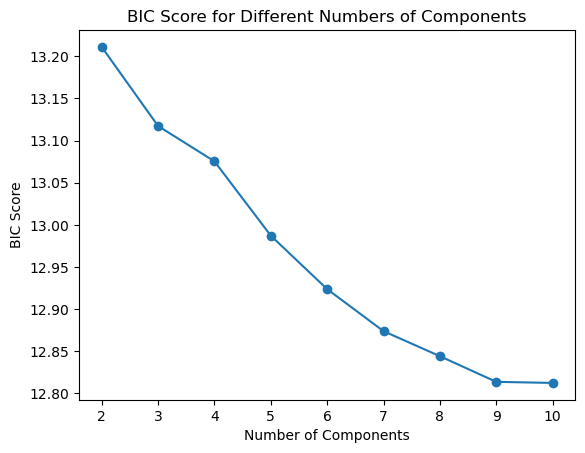

In [14]:
bic_scores = []

for n_components in range(2,11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_umap)
    bic_scores.append(np.log(gmm.bic(X_umap)))

plt.plot(range(2,11), bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score for Different Numbers of Components')
plt.show()

##### The BIC score of n_components should be as low as possible, whereas the Silhouette Score should be as high as possible. But, we should also keep see where the tangent forms and from which point there is no significant increase.

##### From the BIC graph, we see that tangent could be n=8 or n=9. At n=10, there is no significant difference or increase.
##### From Silhouette Graph, it is evident that n=9 gives 0.8 score, whereas n=8 gives ~0.77

##### After trying the GMM for both n=8 and n=9, we see that n=9 is more spaced out i.e clusters are far from each other. Also with n=8, the clusters 2 of the clusters are having centroid between the denser regions of the population.

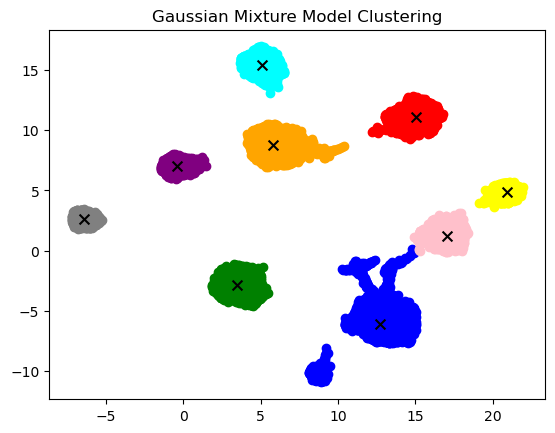

In [15]:
# Fit for 9 clusters
num_clusters = 9
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(X_umap)

# Assign clusters based on the probabilities
cluster_assignments = gmm.predict(X_umap)
probs = gmm.predict_proba(X_umap)

# Plot the clusters on 2D plane
colors = ['red', 'green', 'blue', 'aqua', 'yellow', 'orange', 'purple', 'pink', 'grey', 'cyan']
for i in range(num_clusters):
    plt.scatter(X_umap[cluster_assignments == i, 0], X_umap[cluster_assignments == i, 1], color=colors[i], label=f'Cluster {i+1}')

plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.show()

In [ ]:
# Fit for 8 clusters
num_clusters = 8
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(X_umap)

# Assign clusters based on the probabilities
cluster_assignments = gmm.predict(X_umap)
probs = gmm.predict_proba(X_umap)

# Plot the clusters on 2D plane
colors = ['red', 'green', 'blue', 'aqua', 'yellow', 'orange', 'purple', 'pink', 'grey', 'cyan']
for i in range(num_clusters):
    plt.scatter(X_umap[cluster_assignments == i, 0], X_umap[cluster_assignments == i, 1], color=colors[i], label=f'Cluster {i+1}')

plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD

# We consumed a lot of time to generate the plot and SVD DTM for range(2, 500), so we stopped at the range of 2 to 234
n_components_range = range(2, 234) 
explained_variance = []

for nc in n_components_range:
    svd = TruncatedSVD(n_components=nc)
    svd_dtm = svd.fit_transform(dtm)
    explained_variance.append(np.sum(svd.explained_variance_ratio_))

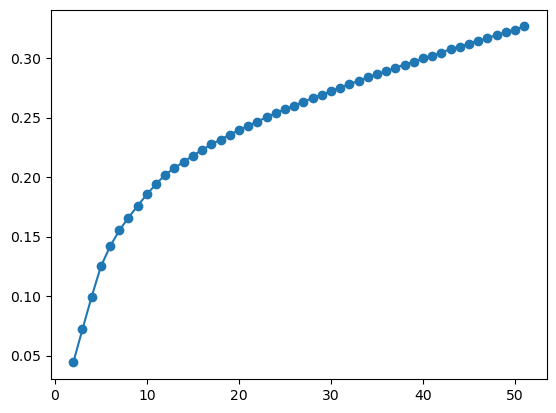

In [29]:
# plot of explained variances for 50 components
plt.plot(range(2,52), explained_variance[:50], marker='o')
plt.show()

#### From the above Silhouette Score of SVD, we see that elbow occurs at 0.2 variance, so we have taken n=12 for SVD and generated a new DTM with only 12 components/features.

In [30]:
# generate svd_dtm using optimal number of components
svd = TruncatedSVD(n_components=12)
svd_dtm = svd.fit_transform(dtm)
explained_var = np.sum(svd.explained_variance_ratio_)
explained_var

0.20205135452180256

In [35]:
svd_dtm.shape

(42146, 12)

##### We will use KMeans for clustering the patient notes. In order to determine the optimal cluster_numbers (K), we will check the avg scores (silhouette). Then use the optimal_k to classify the patients from the SVD generate DTM.

For n_clusters = 4, the average silhouette_score is : 0.33710415863885584
For n_clusters = 5, the average silhouette_score is : 0.3747310409844928
For n_clusters = 6, the average silhouette_score is : 0.44673220884595677
For n_clusters = 7, the average silhouette_score is : 0.481665153938018
For n_clusters = 8, the average silhouette_score is : 0.49790955238614404
For n_clusters = 9, the average silhouette_score is : 0.5319161590885807
For n_clusters = 10, the average silhouette_score is : 0.5327105552995182
For n_clusters = 11, the average silhouette_score is : 0.4473679979172758
For n_clusters = 12, the average silhouette_score is : 0.3747567178125009


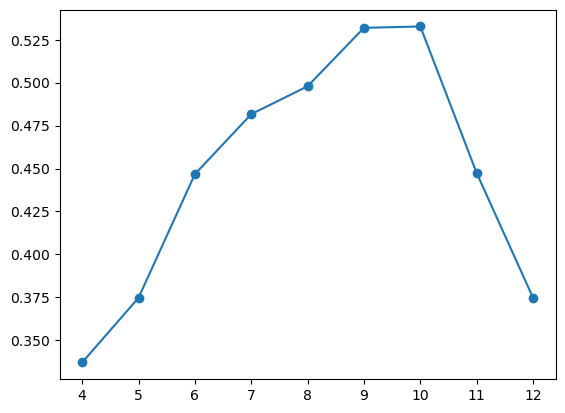

In [32]:
from sklearn.cluster import KMeans

silhouette_scores_km = []

# used the range 4 to 13 to show the increase and decrease of silhouette scores effectively
for k in range(4, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(svd_dtm)

    silhouette_avg = silhouette_score(svd_dtm, labels)
    silhouette_scores_km.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")
    
plt.plot(range(4, 13), silhouette_scores_km, marker='o')

#### From the above silhouette score graph, we can see that optimal K=9 since after that there is a slight increase and post K=10 there is a huge decrease.

In [33]:
# generate final KMeans clusters based on optimal_k
optimal_k = 9
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(svd_dtm)
df_dtm['cluster_label'] = final_labels
df_dtm.head()

,10,11,12,13,14,15,17,17yo,1pp,1x,...,wt,x2,x3,year,years,yesterday,yo,yr,yrs,cluster_label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.120936,0.000000,0.0,0.0,...,0.157179,0.0,0.0,0.073555,0.0,0.0,0.000000,0.000000,0.0,8
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.189568,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.096085,0.000000,0.0,8
2,0.060407,0.0,0.0,0.0,0.0,0.0,0.109430,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,8
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.136828,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.069353,0.172446,0.0,8
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.171976,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,8


### Results and Conclusion

##### Using SVD and K-Means Clustering Techniques, we gain a silhouette score of 0.525 at max covering 20.2% of total variance using `optimal_k (KMeans)=9` and `SVD_N=12`

##### Using UMAP and Guassian Mixture Models, we gain a silhouette score of ~80% with `num_clusters (GMM) = 9`, `n_components=2`, `min_dist=0.5`, `n_neighbors=40`, and `metric=cosine`.

##### Looking at the performance of both the pipelines, we could say that UMAP with GMM performs far efficiently than SVD + KMeans. But, UMAP and GMM are time consuming as compared to SVD and KMeans.

In [41]:
### Separator

### Possible Improvements:

##### Since UMAP gives better results with only 2 components by default, we can finetune the parameters and try to gain the most out of it using some sophisticated evaluation technique (to be explored)

##### For SVD and KMeans, we could use a better preprocessing technique which could contribute more to the explained variance and then the model performance (silhouette score)